In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
county_dems = pd.read_csv(r'.\stitched_data\county_dems.csv', index_col = 0)
res = pd.get_dummies(county_dems['primary_type'])
county_dems = pd.concat([county_dems, res], axis = 1)

candidates = county_dems[['1st','2nd','3rd']].as_matrix().flatten()
candidates = set(candidates)
colNames = county_dems.columns.values
X_names = colNames[22:]
print X_names

['PST045214' 'PST040210' 'PST120214' 'POP010210' 'AGE135214' 'AGE295214'
 'AGE775214' 'SEX255214' 'RHI125214' 'RHI225214' 'RHI325214' 'RHI425214'
 'RHI525214' 'RHI625214' 'RHI725214' 'RHI825214' 'POP715213' 'POP645213'
 'POP815213' 'EDU635213' 'EDU685213' 'VET605213' 'LFE305213' 'HSG010214'
 'HSG445213' 'HSG096213' 'HSG495213' 'HSD410213' 'HSD310213' 'INC910213'
 'INC110213' 'PVY020213' 'BZA010213' 'BZA110213' 'BZA115213' 'NES010213'
 'SBO001207' 'SBO315207' 'SBO115207' 'SBO215207' 'SBO515207' 'SBO415207'
 'SBO015207' 'MAN450207' 'WTN220207' 'RTN130207' 'RTN131207' 'AFN120207'
 'BPS030214' 'LND110210' 'POP060210' 'Closed caucus' 'Closed primary'
 'Open caucus' 'Open primary' 'Semi-closed caucus' 'Semi-closed primary'
 'Semi-open caucus' 'Semi-open primary']


In [17]:
# As there are so many candidates, for simplicity I just run it for Clinton and Sanders as they have the most data.
# Can add more if you think necessary.

county_dems['Clinton'] = np.nan
county_dems['Sanders'] = np.nan
for idx, row in county_dems.iterrows():
    if row['1st'] == 'H. CLINTON':
        county_dems.loc[idx, 'Clinton'] = row['edge1']
    elif row['1st'] == 'B. SANDERS':
        county_dems.loc[idx, 'Sanders'] = row['edge1']
    
    if row['2nd'] == 'H. CLINTON':
        county_dems.loc[idx, 'Clinton'] = row['edge2']
    elif row['2nd'] == 'B. SANDERS':
        county_dems.loc[idx, 'Sanders'] = row['edge2']

In [18]:
from sklearn import linear_model
def runRegression(trainset,testset, model):
    trainset = trainset[~trainset['Clinton'].isnull()]
    trainset = trainset.fillna(trainset.mean())
    testset = testset.fillna(testset.mean())
    test_state = testset['state'][~testset['state'].duplicated()]
    reg = model.fit(trainset[X_names], trainset[['Clinton','Sanders']])
    
    score_series = {}
    for this_state in test_state.values:
        this_test = testset.loc[testset['state']==this_state]
    
        pred_edge = model.predict(this_test[X_names])
        pred_score = model.score(this_test[X_names], this_test[['Clinton','Sanders']])
        
        score_series[this_state] = [pred_score]
    score_series = pd.DataFrame(score_series, index = ['Score']).T
    score_series = bigday_list.merge(score_series, how = 'outer', left_on = 'State', right_index = True)
    #score_series = score_series.sort_values('Date')

    return score_series

In [27]:
#Create samples
states_dems = pd.read_csv(r'.\stitched_data\states_dems.csv', parse_dates = ['Date'])
bigday_list = states_dems[['Date','State']].sort_values('Date')
bigday_list = bigday_list[~bigday_list['State'].duplicated(keep = 'last')]
bigday = bigday_list[~bigday_list['Date'].duplicated()]
bigday = bigday.loc[bigday['Date']>=datetime(2016,3, 1), 'Date'].tolist()

source = county_dems
nodata_list = [x for x in bigday_list['State'].values if len(source.loc[source['state']==x])<=1]

bigday_list = bigday_list[~bigday_list['State'].isin(nodata_list)]

model1 = linear_model.Ridge(alpha = 100, normalize = True)

for idx in range(len(bigday)-1):
    train_state = bigday_list.loc[bigday_list['Date']<=bigday[idx], 'State']
    test_state  = bigday_list.loc[bigday_list['Date']> bigday[idx] ,'State']
    trainset = source[source['state'].isin(train_state.values)]
    testset = source[source['state'].isin(test_state.values)]
    score_series = runRegression(trainset, testset,model1)
    
    if idx ==0:
        score_result = score_series
    else:
        score_result['Score'+str(idx+1)] = score_series['Score']
    #break
        
score_result = score_result[score_result['Date']> datetime(2016,3,1)]  
score_result = score_result.set_index(['Date','State'])
score_result


Score      Score2      Score3      Score4  \
Date       State                                                            
2016-03-05 Louisiana        -0.406332         NaN         NaN         NaN   
2016-03-06 Maine            -5.241482   -5.513730         NaN         NaN   
2016-03-08 Mississippi      -1.405942   -1.541259   -1.553349         NaN   
           Michigan         -2.630339   -2.796182   -2.725917         NaN   
2016-03-15 North Carolina   -0.258260   -0.326245   -0.306889   -0.129708   
           Missouri         -0.099111   -0.108593   -0.104339   -0.079845   
           Ohio             -0.034006   -0.036305   -0.030546   -0.049027   
           Florida          -0.017146   -0.003704   -0.009352   -0.055729   
           Illinois         -1.074481   -1.152166   -1.122436   -0.891340   
2016-03-22 Arizona          -0.319145   -0.263146   -0.294945   -0.406577   
           Idaho            -2.990796   -3.225067   -3.114881   -2.608236   
           Utah             -6.960692   -7.315505   -7.119251   -6.494486   
2016-03-26 Hawaii          -24.589693  -25.243798  -25.147943  -24.784581   
2016-04-05 Wisconsin        -3.135813   -3.298111   -3.236622   -2.748967   
2016-04-09 Wyoming          -1.457030   -1.521884   -1.508792   -1.314047   
2016-04-19 New York         -1.269046   -1.443955   -1.382978   -1.000886   
2016-04-26 Rhode Island    -26.204240  -27.065386  -26.227433  -25.388702   
           Pennsylvania     -1.397853   -1.443133   -1.381352   -1.425261   
           Maryland         -0.613351   -0.529003   -0.526133   -0.836574   
           Delaware        -13.459774  -12.030435  -12.742203  -15.775040   
           Connecticut      -2.506405   -2.184726   -2.311784   -3.072944   
2016-05-03 Indiana          -0.815958   -0.868726   -0.831312   -0.732887   
2016-05-10 Nebraska         -0.064477   -0.075624   -0.071016   -0.049790   
           West Virginia    -3.828987   -4.319997   -4.197764   -3.418975   
2016-05-17 Kentucky         -0.809283   -0.915429   -0.873278   -0.665643   
           Oregon           -2.188046   -2.315654   -2.256884   -2.021095   
2016-05-24 Washington     -131.413485 -133.906181 -132.692959 -126.168902   
2016-06-07 South Dakota      0.015649    0.004299    0.008073    0.018436   
           California       -0.079381   -0.075497   -0.078854   -0.080608   
           Montana          -0.689984   -0.721978   -0.706827   -0.621259   
           New Jersey       -1.459724   -1.365281   -1.427453   -1.623788   
           New Mexico       -0.139242   -0.166552   -0.165375   -0.090616   

                               Score5      Score6      Score7      Score8  \
Date       State                                                            
2016-03-05 Louisiana              NaN         NaN         NaN         NaN   
2016-03-06 Maine                  NaN         NaN         NaN         NaN   
2016-03-08 Mississippi            NaN         NaN         NaN         NaN   
           Michigan               NaN         NaN         NaN         NaN   
2016-03-15 North Carolina         NaN         NaN         NaN         NaN   
           Missouri               NaN         NaN         NaN         NaN   
           Ohio                   NaN         NaN         NaN         NaN   
           Florida                NaN         NaN         NaN         NaN   
           Illinois               NaN         NaN         NaN         NaN   
2016-03-22 Arizona          -0.586139         NaN         NaN         NaN   
           Idaho            -2.065527         NaN         NaN         NaN   
           Utah             -5.656068         NaN         NaN         NaN   
2016-03-26 Hawaii          -24.865143  -18.589168         NaN         NaN   
2016-04-05 Wisconsin        -2.292789   -2.189482   -2.180517         NaN   
2016-04-09 Wyoming          -1.151368   -1.122725   -1.121136   -1.047169   
2016-04-19 New York         -0.656438   -0.572650   -0.567154   -0.448449   
2016-04-26 Rhode Island    

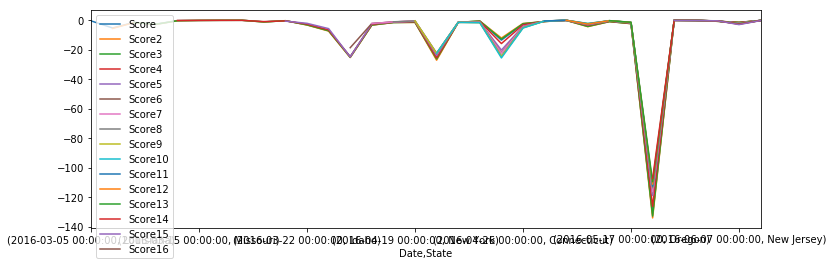

In [28]:
score_result.plot(figsize = (12,4))